In [1]:
!pip install statsforecast

import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import matplotlib.pyplot as plt
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import OneHotEncoder
from pylab import rcParams
import os
  
# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 


StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 3, Finished, Available, Finished)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 58.2 MB/s eta 0:00:00


In [2]:
# Load dataset
konya = pd.read_parquet("abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/konya_features.parquet")

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 4, Finished, Available, Finished)

In [3]:
# vizualize dataset
konya.head()
konya.tail()

# print info
print(konya.info())

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 5, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532614 entries, 0 to 532613
Data columns (total 32 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   store_id               532614 non-null  object        
 1   product_id             532614 non-null  object        
 2   date                   532614 non-null  datetime64[ns]
 3   sales                  532614 non-null  float64       
 4   revenue                532614 non-null  float64       
 5   stock                  532614 non-null  float64       
 6   price                  531602 non-null  float64       
 7   promo_type_1           532614 non-null  category      
 8   promo_bin_1            75780 non-null   category      
 9   promo_type_2           532614 non-null  category      
 10  promo_bin_2            479 non-null     category      
 11  promo_discount_2       479 non-null     float64       
 12  promo_discount_type_2  479 non-null     cate

In [4]:
# change dtypes 

cat_col = ['store_id', 'product_id', 'season', 'week']
konya[cat_col] = konya[cat_col].astype('category')

# Drop columns not necessary
df = konya.copy()
# List of columns to drop
columns_to_drop = [
    'promo_bin_1', 
    'promo_bin_2',
    'revenue', 
    'promo_discount_2', 
    'promo_discount_type_2', 
    'hierarchy2_id', 
    'hierarchy3_id', 
    'hierarchy4_id', 
    'hierarchy5_id', 
    'city_id_old', 
    'country_id', 
    'city_code',
    'product_length', 
    'product_depth',
    'product_width',
    'weekday'
]

# Drop the specified columns
df = df.drop(columns=columns_to_drop, errors='ignore')

#confirm drop
df.info()

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 6, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532614 entries, 0 to 532613
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   store_id       532614 non-null  category      
 1   product_id     532614 non-null  category      
 2   date           532614 non-null  datetime64[ns]
 3   sales          532614 non-null  float64       
 4   stock          532614 non-null  float64       
 5   price          531602 non-null  float64       
 6   promo_type_1   532614 non-null  category      
 7   promo_type_2   532614 non-null  category      
 8   cluster_id     532614 non-null  category      
 9   hierarchy1_id  532614 non-null  category      
 10  storetype_id   532614 non-null  category      
 11  store_size     532614 non-null  int64         
 12  season         532614 non-null  category      
 13  week           532614 non-null  category      
 14  holiday        532614 non-null  category      
 15  

In [5]:
# Get unique store_ids
unique_store_ids = df['store_id'].unique()

# Create a dictionary of DataFrames, each keyed by store_id
store_datasets = {}
for store_id in unique_store_ids:
    store_datasets[store_id] = df[df['store_id'] == store_id].copy()

# dataset for store_id 'S0142'
store_S0142	 = store_datasets['S0142']
print("Store S0142 dataset:")
print(store_S0142.head())

# dataset for store_id S0094
store_S0094	 = store_datasets['S0094']
print("Store S0094 dataset:")
print(store_S0094.head())

# dataset for store_id S0030
store_S0030	 = store_datasets['S0030']
print("Store S0030 dataset:")
print(store_S0030.head())


StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 7, Finished, Available, Finished)

Store S0142 dataset:
       store_id product_id       date  sales  stock  price promo_type_1  \
329161    S0142      P0001 2017-01-02    0.0    1.0   6.25         PR14   
329162    S0142      P0005 2017-01-02    0.0    2.0  33.90         PR14   
329163    S0142      P0015 2017-01-02    0.0   12.0   2.60         PR14   
329164    S0142      P0017 2017-01-02    0.0   17.0   1.49         PR14   
329165    S0142      P0018 2017-01-02    0.0    2.0   1.95         PR14   

       promo_type_2 cluster_id hierarchy1_id storetype_id  store_size season  \
329161         PR03  cluster_5           H01         ST04          31      1   
329162         PR03  cluster_9           H03         ST04          31      1   
329163         PR03  cluster_1           H00         ST04          31      1   
329164         PR03  cluster_6           H00         ST04          31      1   
329165         PR03  cluster_4           H00         ST04          31      1   

       week holiday month_name  
329161    1   

In [6]:
# select store as df
df1 = store_S0030.copy() # replace according to store
df1

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 8, Finished, Available, Finished)

,store_id,product_id,date,sales,stock,price,promo_type_1,promo_type_2,cluster_id,hierarchy1_id,storetype_id,store_size,season,week,holiday,month_name
0,S0030,P0015,2017-01-02,0.0,4.0,2.60,PR14,PR03,cluster_1,H00,ST03,13,1,1,N,Jan
1,S0030,P0018,2017-01-02,1.0,5.0,1.95,PR14,PR03,cluster_4,H00,ST03,13,1,1,N,Jan
2,S0030,P0035,2017-01-02,2.0,1.0,2.45,PR14,PR03,cluster_7,H00,ST03,13,1,1,N,Jan
3,S0030,P0051,2017-01-02,0.0,27.0,0.70,PR14,PR03,cluster_7,H00,ST03,13,1,1,N,Jan
4,S0030,P0055,2017-01-02,0.0,12.0,3.50,PR05,PR03,cluster_0,H00,ST03,13,1,1,N,Jan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62041,S0030,P0694,2019-09-30,1.0,2.0,7.50,PR14,PR03,cluster_9,H00,ST03,13,3,40,N,Sep
62042,S0030,P0709,2019-09-30,0.0,9.0,7.00,PR12,PR03,cluster_9,H00,ST03,13,3,40,N,Sep
62043,S0030,P0711,2019-09-30,0.0,25.0,12.90,PR14,PR03,cluster_0,H03,ST03,13,3,40,N,Sep
62044,S0030,P0718,2019-09-30,0.0,5.0,23.75,PR14,PR03,cluster_0,H00,ST03,13,3,40,N,Sep


In [7]:
# get number of product_ids from store

store_S0030['product_id'].nunique()

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 9, Finished, Available, Finished)

122

## S0030

In [8]:
# Change the granularity of time series data from daily to weekly

# Set 'ds' column as the index
df1.set_index('date', inplace=True)
# Sort the DataFrame by the index (dates)
df1.sort_index(inplace=True)

# Group by 'product_id' and resample to weekly frequency
df_weekly = df1.groupby(['product_id']).resample('W-MON').agg({
    'sales': 'sum',  # Aggregate sales data
    'stock': 'last',  # Take the last stock value of the week
    'price': 'last',  # Last price for the week
    'promo_type_1': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'promo_type_2': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'cluster_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'hierarchy1_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'storetype_id': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'store_size': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'season': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'holiday': lambda x: x.mode().iloc[0] if not x.mode().empty else None, 
    'week': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
    'month_name': lambda x: x.mode().iloc[0] if not x.mode().empty else None,  # Mode of categorical variable
}).reset_index()

# Display the weekly aggregated DataFrame
print(df_weekly.head())

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 10, Finished, Available, Finished)

  product_id       date  sales  stock  price promo_type_1 promo_type_2  \
0      P0015 2017-01-02    0.0    4.0    2.6         PR14         PR03   
1      P0015 2017-01-09    1.0    3.0    2.6         PR10         PR03   
2      P0015 2017-01-16    4.0   11.0    2.6         PR10         PR03   
3      P0015 2017-01-23    0.0   11.0    2.6         PR14         PR03   
4      P0015 2017-01-30    3.0    8.0    2.6         PR14         PR03   

  cluster_id hierarchy1_id storetype_id  store_size  season holiday  week  \
0  cluster_1           H00         ST03        13.0     1.0       N   1.0   
1  cluster_1           H00         ST03        13.0     1.0       N   2.0   
2  cluster_1           H00         ST03        13.0     1.0       N   3.0   
3  cluster_1           H00         ST03        13.0     1.0       N   4.0   
4  cluster_1           H00         ST03        13.0     1.0       N   5.0   

  month_name  
0        Jan  
1        Jan  
2        Jan  
3        Jan  
4        Jan  


In [9]:
df_weekly.info()
#df.info()

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 11, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9894 entries, 0 to 9893
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   product_id     9894 non-null   category      
 1   date           9894 non-null   datetime64[ns]
 2   sales          9894 non-null   float64       
 3   stock          9231 non-null   float64       
 4   price          9209 non-null   float64       
 5   promo_type_1   9231 non-null   object        
 6   promo_type_2   9231 non-null   object        
 7   cluster_id     9231 non-null   object        
 8   hierarchy1_id  9231 non-null   object        
 9   storetype_id   9231 non-null   object        
 10  store_size     9231 non-null   float64       
 11  season         9231 non-null   float64       
 12  holiday        9231 non-null   object        
 13  week           9231 non-null   float64       
 14  month_name     9231 non-null   object        
dtypes: category(1), datet

In [10]:
# Sort DataFrame by 'date'
df_weekly = df_weekly.sort_values(by='date')
#df = df.sort_values(by='date')

# Reset index after sorting
df_weekly.reset_index(drop=True, inplace=True)
#df.reset_index(drop=True, inplace=True)

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 12, Finished, Available, Finished)

In [11]:
# Filter products that are present in 2019
products_in_2019 = df_weekly[df_weekly['date'].dt.year == 2019]['product_id'].unique()

# Filter the original DataFrame to include only products sold in 2019
df_filtered = df_weekly.loc[df_weekly['product_id'].isin(products_in_2019)]


# Display the last few rows of the filtered DataFrame
df_filtered.head()

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 13, Finished, Available, Finished)

,product_id,date,sales,stock,price,promo_type_1,promo_type_2,cluster_id,hierarchy1_id,storetype_id,store_size,season,holiday,week,month_name
0,P0015,2017-01-02,0.0,4.0,2.60,PR14,PR03,cluster_1,H00,ST03,13.0,1.0,N,1.0,Jan
1,P0394,2017-01-02,0.0,12.0,1.00,PR14,PR03,cluster_4,H00,ST03,13.0,1.0,N,1.0,Jan
4,P0436,2017-01-02,0.0,22.0,3.00,PR14,PR03,cluster_8,H00,ST03,13.0,1.0,N,1.0,Jan
5,P0438,2017-01-02,0.0,10.0,0.25,PR14,PR03,cluster_0,H00,ST03,13.0,1.0,N,1.0,Jan
6,P0453,2017-01-02,0.0,31.0,5.25,PR14,PR03,cluster_0,H01,ST03,13.0,1.0,N,1.0,Jan


In [12]:
df_filtered.tail()
#df.tail()

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 14, Finished, Available, Finished)

,product_id,date,sales,stock,price,promo_type_1,promo_type_2,cluster_id,hierarchy1_id,storetype_id,store_size,season,holiday,week,month_name
9889,P0611,2019-09-30,0.0,3.0,20.00,PR14,PR03,cluster_0,H03,ST03,13.0,3.0,N,39.0,Sep
9890,P0388,2019-09-30,6.0,0.0,1.50,PR14,PR03,cluster_3,H03,ST03,13.0,3.0,Y,39.0,Sep
9891,P0663,2019-09-30,1.0,10.0,6.75,PR10,PR03,cluster_1,H00,ST03,13.0,3.0,N,39.0,Sep
9892,P0559,2019-09-30,0.0,1.0,33.50,PR06,PR03,cluster_0,H00,ST03,13.0,3.0,N,39.0,Sep
9893,P0374,2019-09-30,0.0,1.0,139.90,PR14,PR03,cluster_0,H03,ST03,13.0,3.0,N,39.0,Sep


In [13]:
#confirm filtering for 2019 products
ff = df_filtered[df_filtered['product_id'] == 'P0018']
ff2 = ff.sort_values(by='date')
ff2.shape

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 15, Finished, Available, Finished)

(0, 15)

# **ARIMA**

### All time range included

In [14]:
# Adjust column names if needed
df_filtered = df_filtered.rename(columns={
    'product_id': 'unique_id',
    'date': 'ds',
    'sales': 'y'
})


# Rename variable
data = df_filtered.copy()

# Ensure 'unique_id' and 'ds' are properly formatted
data['unique_id'] = data['unique_id'].astype(str)
data['ds'] = pd.to_datetime(data['ds'])

# Separate sales and date from exogenous variables
data2 = data[['ds', 'unique_id', 'y']]


# Define AutoArima model
model = [AutoARIMA(season_length=52)]
#Forecast
sf = StatsForecast(models=model, freq='W-MON', n_jobs=-1)

# Define horizon and level for AutoARIMA
horizon = 2
level = [90]

# Forecast
fcst = sf.forecast(df=data2, h=horizon, level=level)
fcst.head()


StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 16, Finished, Available, Finished)

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
P0015,2019-10-07,0.366563,-1.479692,2.212818
P0015,2019-10-14,0.430045,-1.486416,2.346506
P0026,2019-10-07,0.000000,-0.879211,0.879211
P0026,2019-10-14,0.000000,-0.879211,0.879211
P0035,2019-10-07,0.565303,-1.518490,2.649096


In [15]:
# Convert 'ds' to datetime
fcst['ds'] = pd.to_datetime(fcst['ds'])

# Find the maximum date in the dataset
max_date = fcst['ds'].max()

# Calculate the date two weeks before the maximum date
two_weeks_ago = max_date - pd.Timedelta(weeks=2)

# Filter the DataFrame to keep only the rows within the last two weeks
filtered_df2 = fcst[fcst['ds'] > two_weeks_ago]

filtered_df2

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 17, Finished, Available, Finished)

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
P0015,2019-10-07,0.366563,-1.479692,2.212818
P0015,2019-10-14,0.430045,-1.486416,2.346506
P0026,2019-10-07,0.000000,-0.879211,0.879211
P0026,2019-10-14,0.000000,-0.879211,0.879211
P0035,2019-10-07,0.565303,-1.518490,2.649096
...,...,...,...,...
P0711,2019-10-14,0.000000,-3.162672,3.162672
P0718,2019-10-07,0.341611,-0.762704,1.445927
P0718,2019-10-14,0.341486,-0.762957,1.445930


In [ ]:
# save to csv
filtered_df2.to_csv('abfss://Projeto_ii_ML_models@onelake.dfs.fabric.microsoft.com/Konya_sales.Lakehouse/Files/FORECAST_S0030.csv') 

StatementMeta(, , , Cancelled, , Cancelled)

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 18, Finished, Available, Finished)

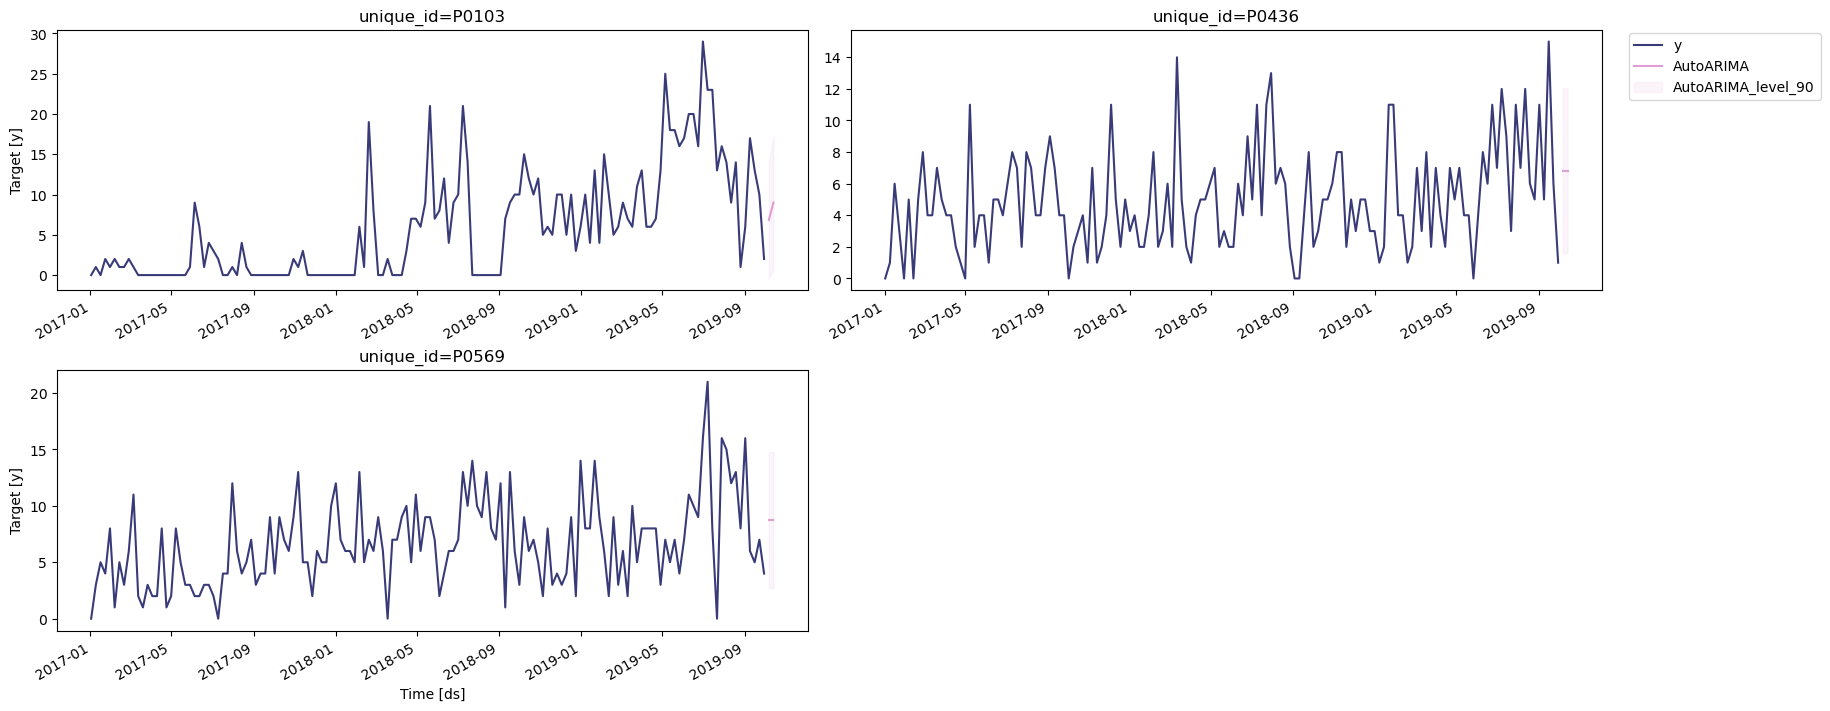

In [16]:
sf.plot(data2, fcst, models=["AutoARIMA"], unique_ids=['P0103', 'P0436', 'P0569'], level=[90])


In [20]:
unique_ids = ['P0103', 'P0436', 'P0569']
filtered_df3 = fcst[fcst['ds'] >= max_date ]

filtered_df3 = filtered_df3.loc[unique_ids]
filtered_df3

StatementMeta(, 538cca17-48a4-492c-aadf-ed437d4a4769, 22, Finished, Available, Finished)

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
P0103,2019-10-14,9.009973,0.682099,17.337847
P0436,2019-10-14,6.825098,1.584950,12.065246
P0569,2019-10-14,8.739407,2.685228,14.793585
